# MaskRCNN Starter

In [1]:
from __future__ import division

In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
from utils import *
from fastai import *
from msk_rcnn import utils, visualize
import msk_rcnn.model as modellib
from msk_rcnn.model import log
from msk_rcnn.custom import *
from msk_rcnn import config
from msk_rcnn import custom
from skimage.io import imread, imshow
from PIL import Image as pil_image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

In [4]:
config = custom.CellConfig()

## Data Prep

In [8]:
train_ids = next(os.walk(trn_path))[1]

In [9]:
# initialize datasets
trn_data = CellDataset()
val_data = CellDataset()


#add classes
trn_data.add_class("dsb",1,"cell")
val_data.add_class("dsb",1,"cell")

#random mask for split
msk = np.random.random(len(train_ids)) < 0.85

#split datasets
for x in range(len(train_ids)):
    if msk[x]:
        trn_data.add_image("dsb", x, trn_path, train_ids[x])
    else:
        val_data.add_image("dsb", x, trn_path, train_ids[x])

In [10]:
#after setting classes and loading images, you need to prepare the dataset
trn_data.prepare()
val_data.prepare()

print("Image Count: {}".format(len(trn_data.image_ids)))
print("Class Count: {}".format(trn_data.num_classes))
for i, info in enumerate(trn_data.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 566
Class Count: 2
  0. BG                                                
  1. cell                                              


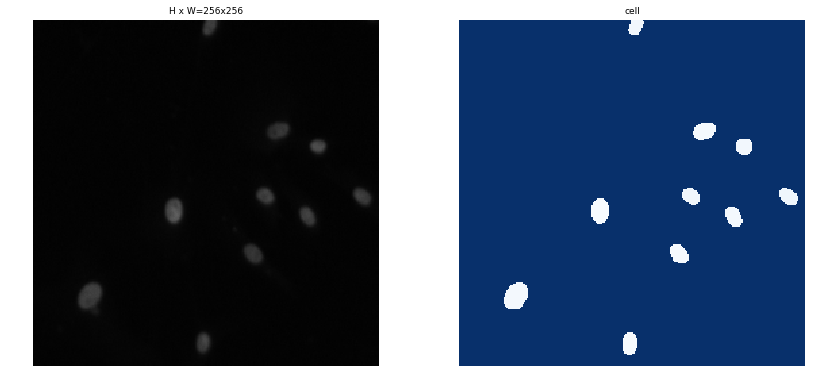

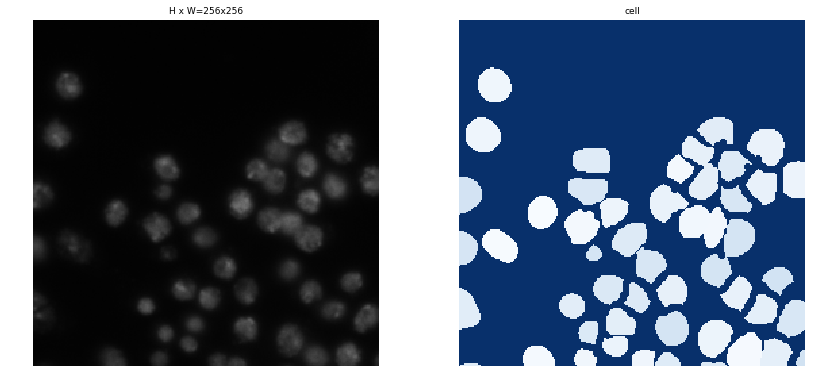

In [11]:
image_ids = np.random.choice(trn_data.image_ids,2)
for image_id in image_ids:
    image = trn_data.load_image(image_id)
    mask, class_ids = trn_data.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, trn_data.class_names, limit=1)

## Bounding Boxes

From this, one thing that comes to mind is the possibility of adding another class for nucleus instead of cell. Not sure if it would help or not, but the brightfield images that target the tiny nuclei in the center of cells seem very different from the full size cell. I could see those images being troublesome. I'll have to experiment later.

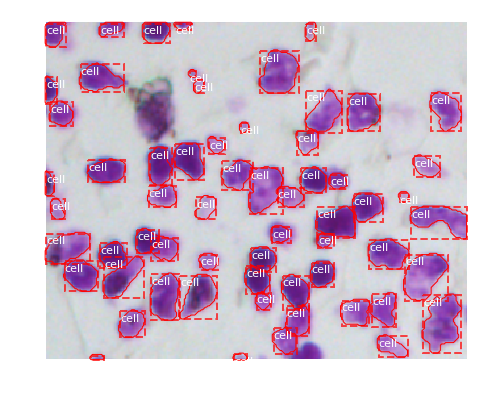

In [16]:
#get bboxes for random image
image_id = 2 #np.random.choice(trn_data.image_ids)
image = trn_data.load_image(image_id)
mask, class_ids = trn_data.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

visualize.display_instances(image, bbox, mask, class_ids, trn_data.class_names, figsize=(8,8))

In [17]:
mask.shape

(256, 320, 61)

In [18]:
image.shape

(256, 320, 3)

In [19]:
image.max()

243

## Image Resizing

Most images are in the 256x256 bin. For now, I'll try to save memory and stick with resizing to 256x256. If results are poor on larger images I can change it easily. I made a custom function for this and it seems to work well.

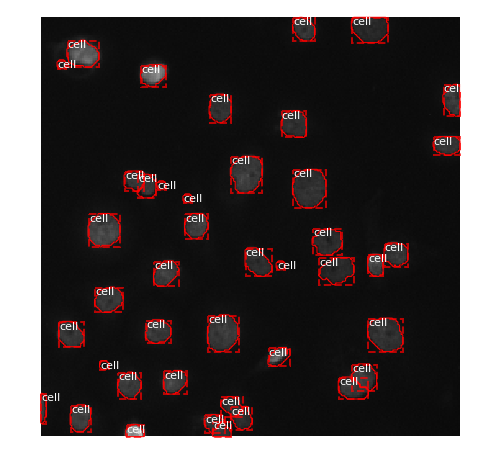

In [20]:
image_id = 345 #np.random.choice(trn_data.image_ids)
image = trn_data.load_image(image_id)
mask, class_ids = trn_data.load_mask(image_id)
original_size = image.shape

image, window, scale, padding = utils.resize_image(
    image,
    min_dim = config.IMAGE_MIN_DIM,
    max_dim = config.IMAGE_MAX_DIM,
    padding = True
)
mask = utils.resize_mask(mask, scale, padding)
bbox = utils.extract_bboxes(mask)
visualize.display_instances(image, bbox, mask, class_ids, trn_data.class_names, figsize=(8,8))

<strong>Watch for resizing that gives float values for images instead of regular 0-255 ranges!!!</strong>

## Mini Masks

Storing a separate image for each object instance takes up a lot of space. Using mini masks reduces the memory requirement. I want to make sure they still work correctly with the other adjustments that I made.

mask                     shape: (56, 56, 42)          min:    0.00000  max:    1.00000
345


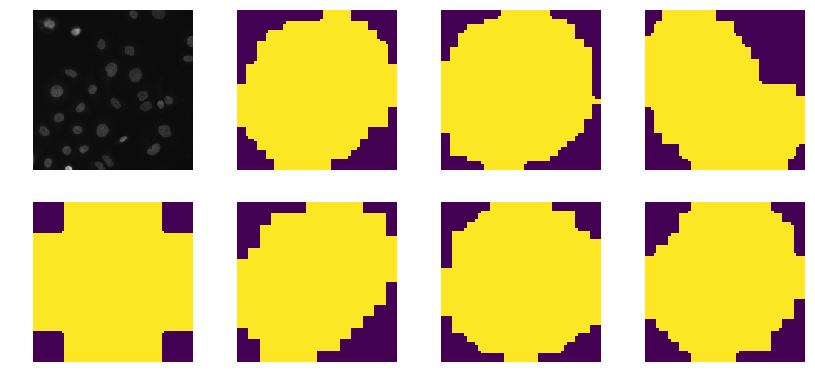

In [21]:
image_id = 345 #np.random.choice(trn_data.image_ids)
image, image_meta, class_ids, bbox, mask =  modellib.load_image_gt(
    trn_data,
    config,
    image_id,
    augment=True,
    use_mini_mask=True
)

log("mask", mask)
print(image_id)
visualize.display_images([image] + [mask[:,:,i] for i in range(min(mask.shape[-1],7))])

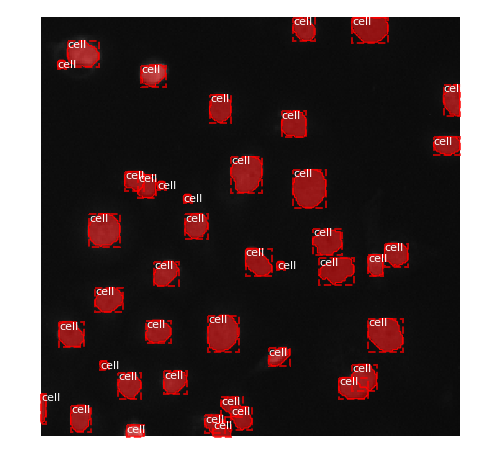

In [22]:
mask = utils.expand_mask(bbox,mask,image.shape)
visualize.display_instances(image, bbox, mask, class_ids, trn_data.class_names, figsize=(8,8))

## Anchors

The anchors are the first reference points for making the bounding boxes. Larger anchors go with larger feature maps

In [23]:
# Generate Anchors
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          config.BACKBONE_SHAPES,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(config.BACKBONE_SHAPES)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = config.BACKBONE_SHAPES[l][0] * config.BACKBONE_SHAPES[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

('Count: ', 16368)
('Scales: ', (16, 32, 64, 128, 256))
('ratios: ', [0.5, 1, 2])
('Anchors per Cell: ', 3)
('Levels: ', 5)
Anchors in Level 0: 12288
Anchors in Level 1: 3072
Anchors in Level 2: 768
Anchors in Level 3: 192
Anchors in Level 4: 48


/home/ubuntu/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Level 0. Anchors:  12288  Feature map Shape: [128 128]
Level 1. Anchors:   3072  Feature map Shape: [64 64]
Level 2. Anchors:    768  Feature map Shape: [32 32]
Level 3. Anchors:    192  Feature map Shape: [16 16]
Level 4. Anchors:     48  Feature map Shape: [8 8]


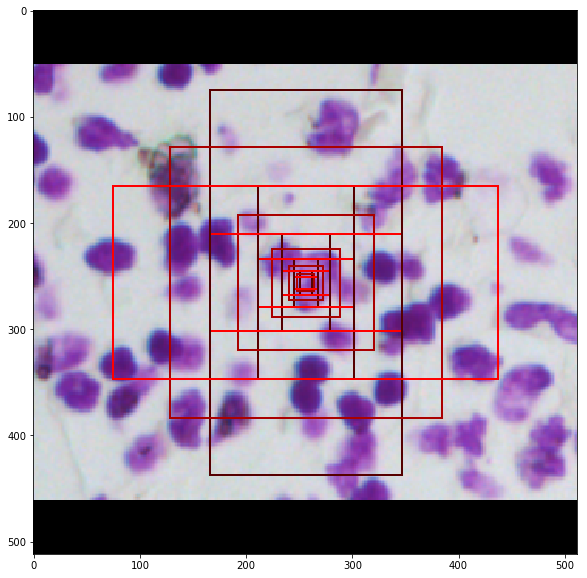

In [24]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = 2 #np.random.choice(trn_data.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(trn_data, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(config.BACKBONE_SHAPES)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                config.BACKBONE_SHAPES[level]))
    center_cell = config.BACKBONE_SHAPES[level] // 2
    center_cell_index = (center_cell[0] * config.BACKBONE_SHAPES[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * config.BACKBONE_SHAPES[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


This confirms that it resizes image correctly with the anchors in place.

## Data Augmentation

In [25]:
#create the data generator
random_rois=2000
g = modellib.data_generator(trn_data, config, random_rois=random_rois, batch_size=2, detection_targets=True)
#for training probably want to keep random_rois at zero and detection_targets at False, 
#otherwise the network will not use the RPN

In [26]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
#for i in range(575):
#     print(i)
#     _, _ = next(g)

In [27]:
#get next images
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match)
log("rpn_bbox", rpn_bbox)
image_id=image_meta[0][0]
print("image id: ", image_id, trn_data.image_reference(image_id))

mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (2, 200, 4)           min:    0.00000  max:  511.00000
mrcnn_class_ids          shape: (2, 200, 1)           min:    0.00000  max:    1.00000
mrcnn_bbox               shape: (2, 200, 2, 4)        min:   -3.00000  max:    2.54098
mrcnn_mask               shape: (2, 200, 28, 28, 2)   min:    0.00000  max:    1.00000
gt_class_ids             shape: (2, 200)              min:    0.00000  max:    1.00000
gt_boxes                 shape: (2, 200, 4)           min:    0.00000  max:  512.00000
gt_masks                 shape: (2, 56, 56, 200)      min:    0.00000  max:    1.00000
rpn_match                shape: (2, 16368, 1)         min:   -1.00000  max:    1.00000
rpn_bbox                 shape: (2, 256, 4)           min:   -3.17128  max:    3.53553
('image id: ', 500, '')


anchors                  shape: (16368, 4)            min: -181.01934  max:  565.01934
refined_anchors          shape: (10, 4)               min:    0.00000  max:  472.00000
Positive anchors: 10
Negative anchors: 246
Neutral anchors: 16112
BG: 172
cell: 28


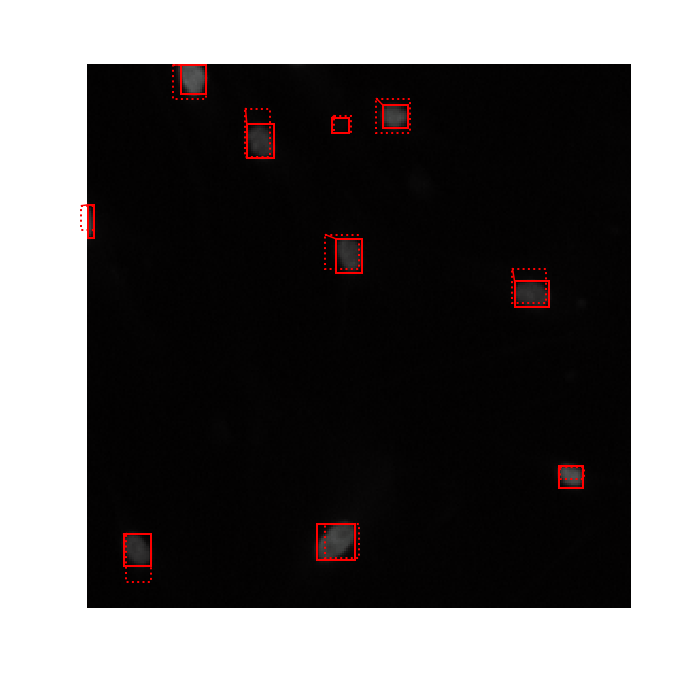

In [28]:
b=0

sample_image = modellib.unmold_image(normalized_images[b], config)

#compute anchor shifts
indices = np.where(rpn_match[b] == 1)[0]
#1 is positive anchors 70% overlap, -1 is less than 30%, 0 is neutral between the two
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)]*config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

#get anchor counts
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

for c, n in zip(trn_data.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{}: {}".format(c, n))
        
#positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], refined_boxes=refined_anchors)

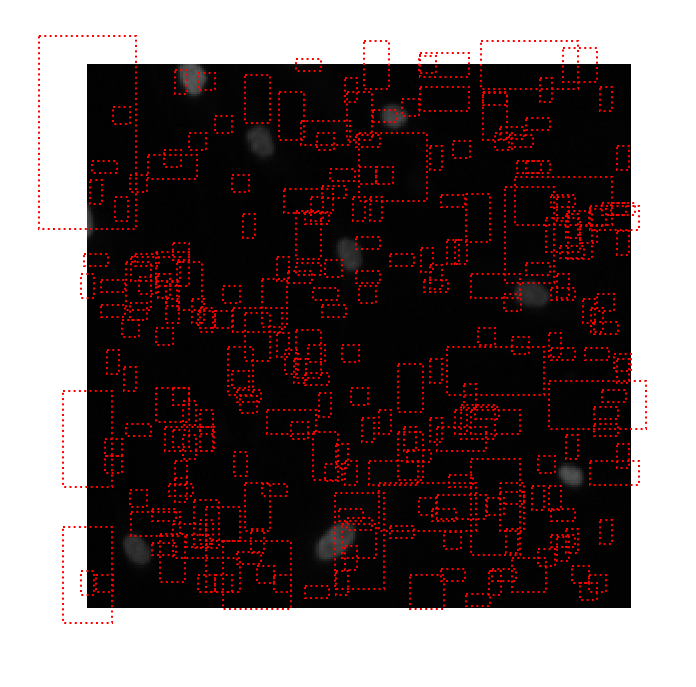

In [29]:
#negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

In [30]:
#neutral anchors, don't do this unless you have small number of max anchors!
#visualize.draw_boxes(sample_image, boxes=anchors[neutral_anchor_ids])

## Regions of Interest

('Positive ROIs: ', 28)
('Negative ROIs: ', 172)
Positive Ratio: 0.00
Unique ROIs: 200 out of 200


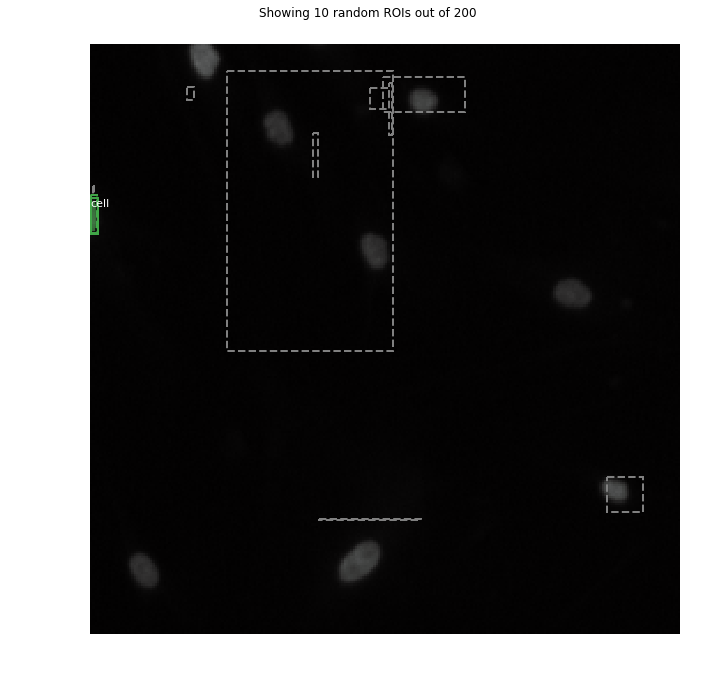

In [31]:
if random_rois:
    #class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]
    
    #refined rois
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4]*config.BBOX_STD_DEV)
    
    #class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]
    
    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], trn_data.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

# Training Model

## Prep

In [12]:
# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [13]:
config.display()


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        200
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               200
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           cells
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING  

In [14]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Model Creation

In [15]:
model = modellib.MaskRCNN('training', config, MODEL_DIR)

In [16]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

#intialization weights, I'll start with coco
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

In [17]:
model.train(trn_data, val_data, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/nbs/dsb2018/logs/cells20180208T1346/mask_rcnn_cells_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
('In model: ', 'rpn_model')
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mr

/home/ubuntu/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:2022: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


/home/ubuntu/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


5/5 [==============================] - 788s 158s/step - loss: 5.6124 - rpn_class_loss: 1.2922 - rpn_bbox_loss: 1.2917 - mrcnn_class_loss: 1.0694 - mrcnn_bbox_loss: 1.2681 - mrcnn_mask_loss: 0.6909 - val_loss: 2.7308 - val_rpn_class_loss: 0.1393 - val_rpn_bbox_loss: 0.7454 - val_mrcnn_class_loss: 0.2705 - val_mrcnn_bbox_loss: 1.0366 - val_mrcnn_mask_loss: 0.5390


## Detection

In [20]:
class InferenceConfig(CellConfig):
    GPU_COUNT=1
    IMAGES_PER_GPU=1
    
inference_config = InferenceConfig()

model = modellib.MaskRCNN('inference', inference_config, MODEL_DIR)

model_path = model.find_last()[1]
model.load_weights(model_path, by_name=True)

original_image:          shape: (512, 512, 3)         min:    1.00000  max:  111.00000
image_meta:              shape: (10,)                 min:    0.00000  max:  512.00000
gt_class_id:             shape: (6,)                  min:    1.00000  max:    1.00000
gt_bbox:                 shape: (6, 4)                min:   52.00000  max:  502.00000
gt_mask:                 shape: (512, 512, 6)         min:    0.00000  max:  255.00000


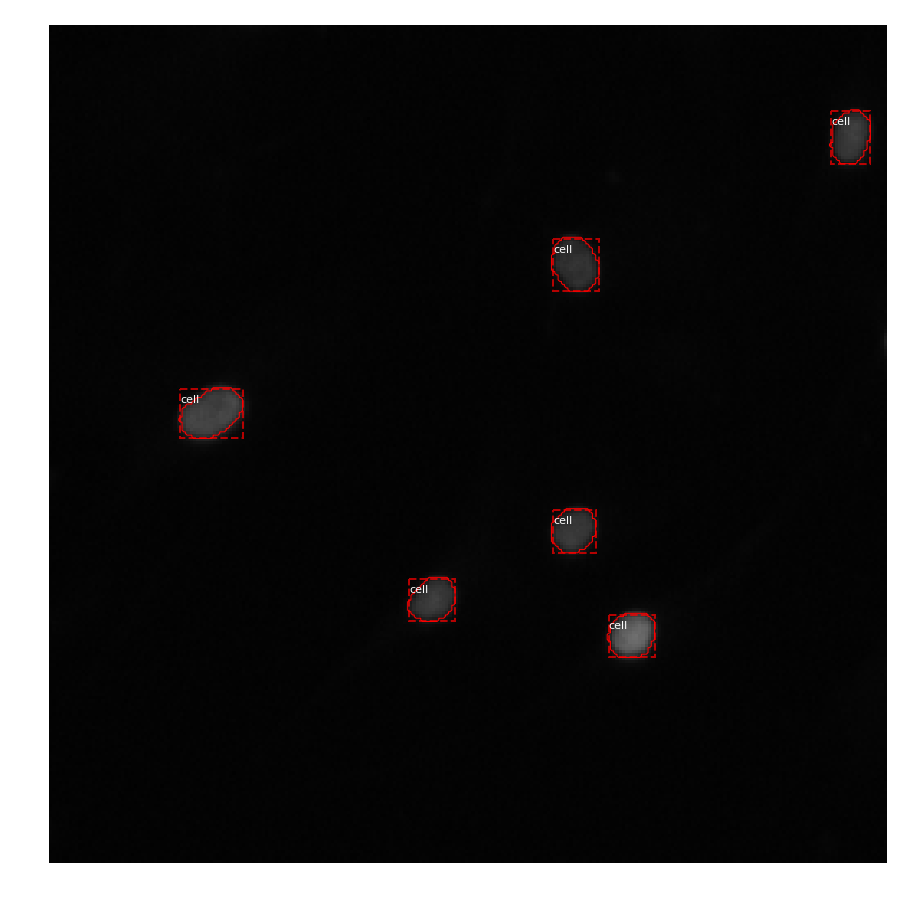

In [21]:
#inspect random image
image_id = np.random.choice(val_data.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(val_data, inference_config, image_id)

log("original_image: ", original_image)
log("image_meta: ", image_meta)
log("gt_class_id: ", gt_class_id)
log("gt_bbox: ", gt_bbox)
log("gt_mask: ", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, val_data.class_names)

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  111.00000
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:    7.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


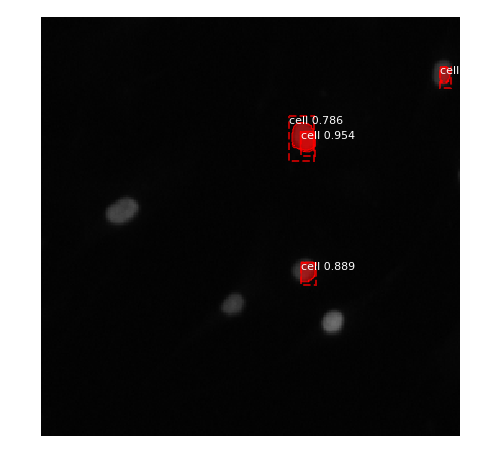

In [22]:
results = model.detect([original_image], verbose=1)
r = results[0]

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            val_data.class_names, r['scores'], ax=get_ax())

## Evaluation

In [23]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(val_data.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(val_data, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

/home/ubuntu/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


('mAP: ', 0.056534275620209948)


# Submission

## Test Data Prep

In [24]:
test_ids = next(os.walk(tst_path))[1]

In [25]:
# initialize test dataset
tst_data = CellDataset()

#add classes
tst_data.add_class("dsb",1,"cell")

#split datasets
for x in range(len(test_ids)):
    tst_data.add_image("dsb", x, tst_path, test_ids[x])

In [26]:
#after setting classes and loading images, you need to prepare the dataset
tst_data.prepare()

print("Image Count: {}".format(len(tst_data.image_ids)))
print("Class Count: {}".format(tst_data.num_classes))
for i, info in enumerate(tst_data.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 65
Class Count: 2
  0. BG                                                
  1. cell                                              


## Inference

Processing 1 images
image                    shape: (524, 348, 3)         min:    0.00000  max:  253.00000
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  145.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  524.00000


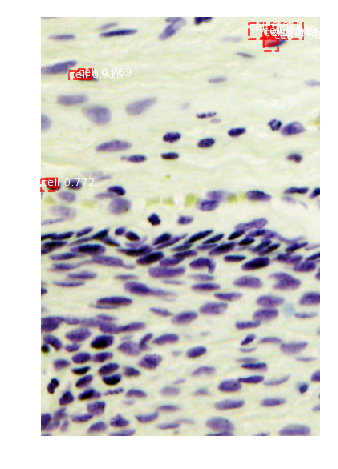

In [101]:
image_id = np.random.choice(tst_data.image_ids)
sample_image = tst_data.load_image(image_id)

preds = model.detect([sample_image], verbose=1)
p = preds[0]

visualize.display_instances(sample_image, p['rois'], p['masks'], p['class_ids'],
                            tst_data.class_names, p['scores'], ax=get_ax())

In [96]:
from tqdm import tqdm

In [97]:
image_names = []
encodings = []

for image_id in tqdm(tst_data.image_ids):
    #get image and predict mask
    image = tst_data.load_image(image_id)
    results = model.detect([image], verbose=0)
    r = results[0]
    masks = np.rollaxis(r['masks'], 2, 0)
    
    for mask in masks:
        #do rle encoding and append it to the array
        image_names.append(tst_data.image_info[image_id]['string'])
        encodings.append(rle_encoding(mask))
        
#check output
#conv = lambda l: ' '.join(map(str, l)) # list -> string
#subject, img = 1, 1
#print('\n{},{}'.format(image_names, encodings))

sub = pd.DataFrame()
sub['ImageId'] = image_names
sub['EncodedPixels'] = pd.Series(encodings).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(path+'results/sub-dsbowl2018-1.csv', index=False)

100%|██████████| 65/65 [25:27<00:00, 23.50s/it]
